# MNIST CNN

In [ ]:
# pip install tensorflow-datasets

In [11]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\annap\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [18]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from functools import partial
import tensorflow_datasets as tfds
from sklearn.datasets import load_sample_image
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

In [15]:
flower = load_sample_image("flower.jpg") / 255
china = load_sample_image("china.jpg") / 255
imgs = np.array([china, flower])
batch_size, height, width, channels = imgs.shape

In [16]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop  

    return image[top_crop:bottom_crop, left_crop:right_crop]  


def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])


def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label



def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)


def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))


def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))


def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

## CNNs

Convolutional neural networks, excellent for image recognition/classification. Can suffer from vanishing gradients or the degredation problems (more layers, worse accuracy). 

This takes around 50 minutes to run

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]



DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")


model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])


model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

X_new = X_test[:10] 
y_pred = model.predict(X_new)

C:\Users\annap\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 214s 121ms/step - accuracy: 0.6444 - loss: 1.0037 - val_accuracy: 0.8606 - val_loss: 0.3818
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 224s 131ms/step - accuracy: 0.8476 - loss: 0.4608 - val_accuracy: 0.8856 - val_loss: 0.3286
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 208s 121ms/step - accuracy: 0.8735 - loss: 0.3806 - val_accuracy: 0.8914 - val_loss: 0.3073
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 278s 130ms/step - accuracy: 0.8881 - loss: 0.3417 - val_accuracy: 0.8976 - val_loss: 0.2938
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 273s 159ms/step - accuracy: 0.8937 - loss: 0.3173 - val_accuracy: 0.8986 - val_loss: 0.2949
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 300s 174ms/step - accuracy: 0.9011 - loss: 0.2907 - val_accuracy: 0.9018 - val_loss: 0.3017
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 330s 192ms/step - accuracy: 0.9039 - loss: 0.2855 - val_accuracy: 0.9004 - val_loss: 0.2963
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 368s 214ms/step - ac

Test Accuracy, Loss

Test Accuracy: 0.8964, Test Loss: 0.3278


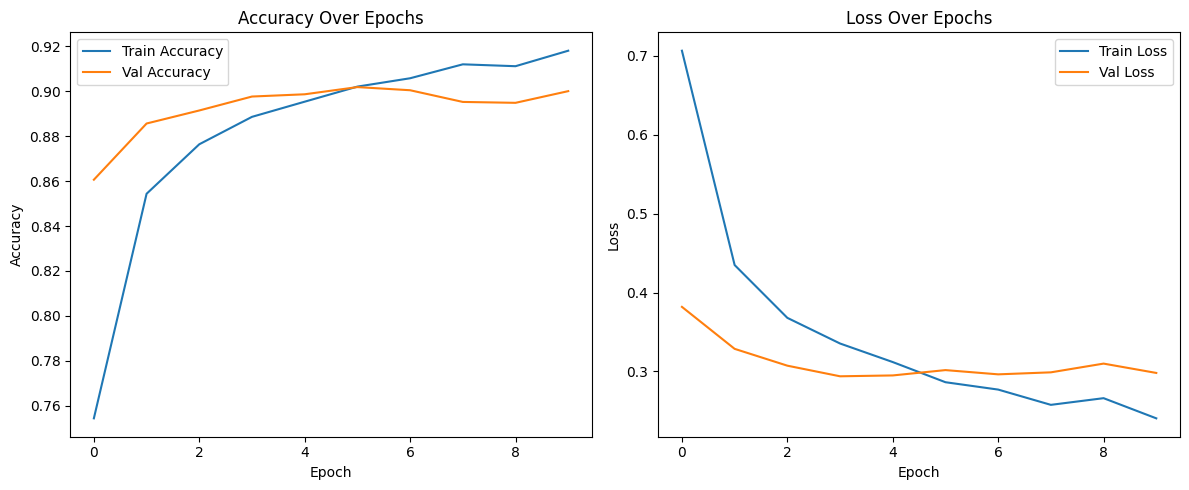

In [12]:
print(f"Test Accuracy: {score[1]:.4f}, Test Loss: {score[0]:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
print(y_test.shape)
print(y_pred_labels.shape)

(10000,)
(10,)


## ResNet-34

residual network = deep conv nn (deep residual learning for image recognition), 

34 layers deep, uses basic residual blocks 

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    



(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full[..., np.newaxis]  # Shape: (60000, 28, 28, 1)
X_test = X_test[..., np.newaxis]              # Shape: (10000, 28, 28, 1)


X_train_resized = tf.image.resize(X_train_full, [224, 224]) / 255.0
X_test_resized = tf.image.resize(X_test, [224, 224]) / 255.0
# X_train = tf.image.grayscale_to_rgb(X_train)
# X_valid = tf.image.grayscale_to_rgb(X_valid)
# X_test_resized = tf.image.grayscale_to_rgb(X_test_resized)

X_train, X_valid = X_train_resized[:-5000], X_train_resized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


model = keras.models.Sequential()
# model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters


model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=5,
    batch_size=32
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_186 (Conv2D)             │ (None, 112, 112, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_181         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_80 (ResidualUnit) │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_81 (ResidualUnit) │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_82 (ResidualUnit) │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_83 (ResidualUnit) │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_84 (ResidualUnit) │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_85 (ResidualUnit) │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_86 (ResidualUnit) │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_87 (ResidualUnit) │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_88 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_89 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_90 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_91 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_92 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_93 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_94 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_95 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,300,554 (81.26 MB)

 Trainable params: 21,283,530 (81.19 MB)

 Non-trainable params: 17,024 (66.50 KB)

Epoch 1/5
  88/1719 ━━━━━━━━━━━━━━━━━━━━ 2:52:37 6s/step - accuracy: 0.4746 - loss: 1.9217

Test Accuracy, Loss

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test Accuracy: {score[1]:.4f}, Test Loss: {score[0]:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## ResNet-50

50 layers deep, uses bottleneck residual blocks (more efficient)

slower than resnet-34 but has higher capacity, handles complexity better

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
info.splits["train"]

images_resized = tf.image.resize(imgs, [224, 224])
images_resized = tf.image.resize_with_pad(imgs, 224, 224, antialias=True)
images_resized = tf.image.resize_with_crop_or_pad(imgs, 224, 224)


class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples


test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)  



plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()


In [ ]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)   


plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

## Transfer Learning Model - Xception architecture

Pretrained Xceptron CNN model from keras, trained on imageNet with added layers of GlobalAveragePooling2D and a Dense Layer. Uses stochastic gradient descent (SGD)

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)


for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

In [ ]:

for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

### Classification / Localization 

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)

model = keras.models.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], 
              optimizer=optimizer, metrics=["accuracy"])


fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

model.fit(fake_train_set, steps_per_epoch=5, epochs=2)


### Mean Average Precision (mAP)

In [ ]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [ ]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)


fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot output for 1st image
ax2.axis("off")
plt.show()

In [ ]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")


fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()